# Process the data
Experiment with Aarhus (2020):
- 18 keV
- pixel = 6.5/40 um
- distances: 135, 140, 144, 152


**Comments**:
<br>
some problems with the data collection for distances 140 and 144 mm.
- In the case of 140mm, the images of section 79 were not recorded – this dataset includes one additional section (120) which was probably recorded to replace 79 but they are not at the same position. Section 79 is part of the sample while section 120 is outside of the sample. That is clear when using images 120 in the position of section 79.
- For 144mm, the images of section 55 were not recorded in between 201.8 and 360 degrees (except for 201.9). This is why I was getting an error when running the stitching function for some slices at distance 144mm – these slices only have 118 images, as opposed to 119.

In [1]:
import numpy as np
from maximus48 import SSIM_131119 as SSIM
from maximus48 import var
import tifffile
import matplotlib.pyplot as plt
import os

# One distance

## Read all paths

In [2]:
folder = '/mnt/beegfs/P14/2020/p3l-gleb1/20201129/RAW_DATA/imaging/'
#folder = '/Users/au704469/Documents/Postdoc/Results/X-ray_tomography/Brain_organoid_P14_DESY_Nov2020/Data_test/'+distance+'mm/'

In [3]:
#create the list all images in the folder
imlist = os.listdir(folder)

## Open one projection for tests

In [4]:
distance = '135mm'
image = '00001.tiff'

In [5]:
# select just one distance and one acquisition/projection
def find_paths_single_distance_all(data_list, key, distance, image):
    return [i for i in data_list if (i.startswith(key) and distance in i and image in i)]

In [6]:
# this is also very ugly way of sorting
def find_counter(string, start, end):
    return (string.split(start))[1].split(end)[0]

In [7]:
def find_ffs_simple(data_list, key):
    """
    Just for one image
    data_list: all data in the folder
    key: name of the file for which ff-s should be found
    """
    outs = [i for i in data_list if i.startswith('ff_'+key)]
    outs.sort()
    return outs

def find_ffs_list(data_list, image_list):
    """
    For a list of images
    data_list: all data in the folder
    image_list: list of images for which you want to find ff-s
    key: name of the file for which ff-s should be found
    """
    all_ff=[]
    for i in image_list:
        one_ff = []
        key = i[:-10]
        one_ff.append(find_ffs_simple(imlist, key))
        all_ff.append(one_ff)
        
    return all_ff

In [8]:
data_test = find_paths_single_distance_all(imlist, key ='try0', distance = distance, image = image)
data_test = sorted(data_test, key=lambda i: int(find_counter(i, start = distance + "_", end = "_"+image)))

In [9]:
ff_test = find_ffs_list(imlist, image_list = data_test)

## Do ff-correction

In [10]:
#set the ROI of image first, the logic corresponds to FIJI (to be read (x,y,x1,y1 at the image - inverse to numpy!)
# ROI = (100,100,2048,2048) 


In [11]:
def ff_correct_one(image_path, ff_data, ROI=(100,100,2048,2048)):    
    """
    This function takes 1 data image and ff corrects it
    
    image_data: str
        path to images
    ff_data: list
        paths to ff
    ROI: (line_start, row_start, line_finish, row_sinish)
        define the area for the ff-correction
        you need to avoid using 100 first rows as they contain logs for PCO images
        
    Returns
    out: 3D numpy array
    """
    

    # read images
    images = tifffile.imread(folder+image_path)
    images = images[ROI[1]:ROI[3], ROI[0]:ROI[2]]

    #read ff-files
    flatfield = np.asarray([tifffile.imread(folder+im) for im in ff_data])
    flatfield = flatfield[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    # please transpose the ff-array for the further ff-correction
    flatfield = np.transpose(flatfield, (1,2,0))
    
    # images should be set as special classes:
    image_class = SSIM.SSIM_const(images)
    ff_class = SSIM.SSIM_const(flatfield)

    # then, you can calculate SSIM metrics for each pair (data-image) - (ff-image)
    index = SSIM.SSIM(image_class, ff_class).ssim()

    # now, simply divide your image by flatfield-image with highest SSIM-index and get a corrected image:
    result = np.asarray(images[:]/flatfield[:,:,np.argmax(index)])
    return result

In [12]:
ff_corrected = []
for counter,image in enumerate(data_test):
    ff_corrected.append(ff_correct_one(image, ff_test[0][0]))

In [13]:
ff_corrected = np.asarray(ff_corrected)

In [15]:
path_to_save = '/mx-beta/anaconda3/mpolikarpov_scripts/2021_Aarhus/test_data/'

In [17]:
np.save(path_to_save+'test_projection_135mm_0001', ff_corrected)

In [54]:
# load the data
ff_corrected = np.load(path_to_save+'test_projection_135mm_0001.npy')

## Evening Ideas 17.01.22

you don't need stiching in the vertical direction at all!

Just find an appropriate solution for the horizontal direction

### auto-find shift between two images

In [56]:
# calculate shift of the image between the i-th and the 1-st distance
from maximus48 import multiCTF2 as multiCTF

motor_step_mm = 0.25*1e-3
pixel_size = 6.5/40 *1e-6
motor_step_pix = motor_step_mm/pixel_size 

image_size = 2048 - 100
crop_area = image_size - int(motor_step_pix)

[ 3.45 11.18]


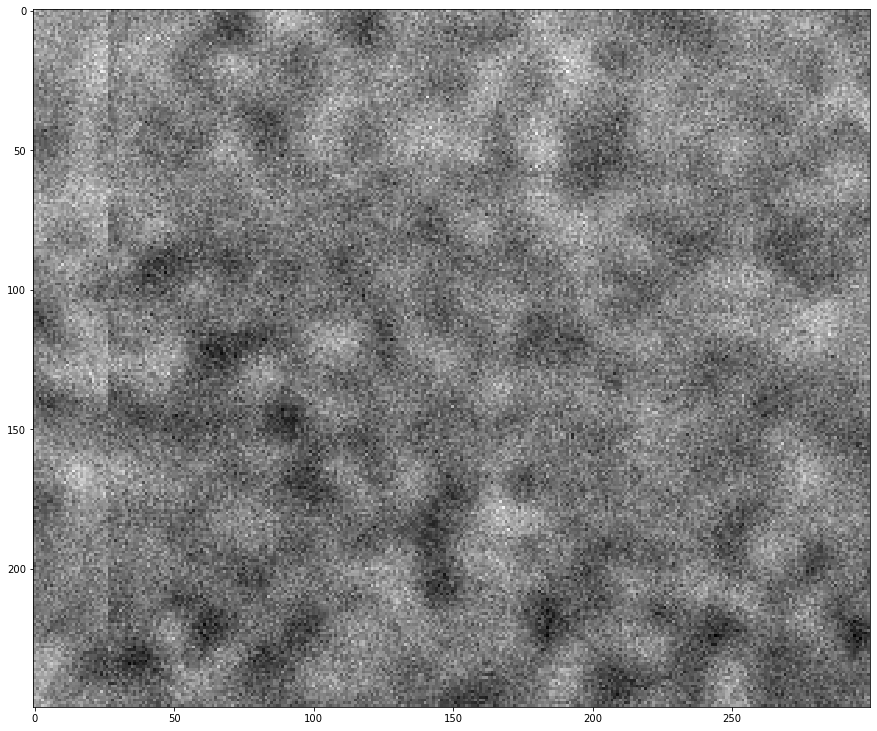

In [104]:
# select images
i = 9 + 3*17

image1 = ff_corrected[i]
image2 = ff_corrected[i-1]


# find shift
shift = multiCTF.shift_distance(image1[:,1500:],
                                image2[:,:2048-100-1500], 100)
print(shift)


# test stiching - horizontal
#cropme = np.s_[:,:int(motor_step_pix)+int(shift[0])]
cropme = np.s_[:,:int(motor_step_pix)-11]

test = np.concatenate([image1[cropme], image2[cropme]], axis = 1)


plt.figure(figsize = (15,15))
plt.imshow(test[1500:1750,1500:1800], cmap = 'gray')

In [133]:
### Test it visually

In [109]:
def Reverse(lst):
    return [ele for ele in reversed(lst)]


def stitchme_from_array(images, crop = np.s_[:,
                                             :int(motor_step_pix) - 50,
                                             :int(motor_step_pix) - 50]):
    
    # this part is questionable, the offset should be calculated better above
    images = images[crop]
    
    outs = []
    for ver in range(7):
        i=ver*17
        current_line = np.concatenate([k for k in reversed(images[i:i+17])], axis = 1)
        outs.append(current_line)
    
    # pack everything in one array and return one image
    outs = np.asarray(Reverse(outs))
    
    return (outs.reshape(outs.shape[0]*outs.shape[1], outs.shape[2]))

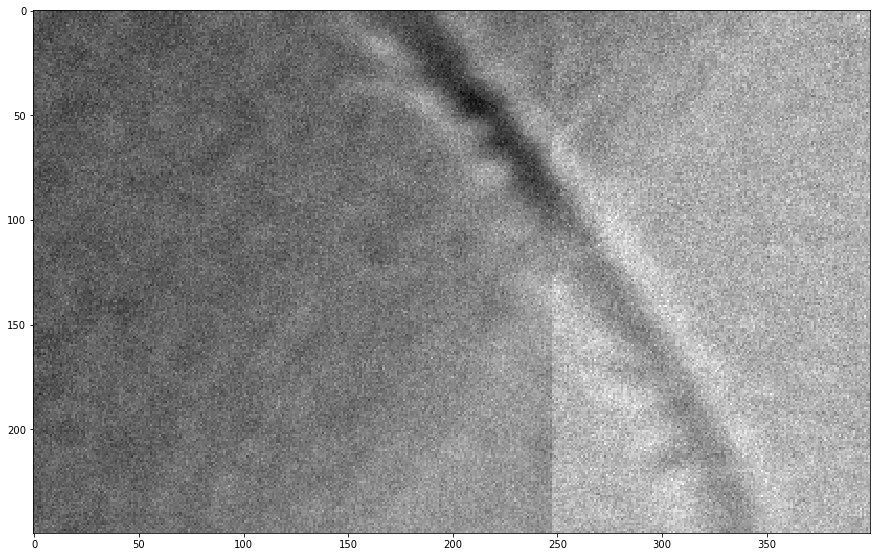

In [132]:
# test stiching - horizontal
motor_step_mm = 0.25*1e-3
pixel_size = 6.5/40 *1e-6
motor_step_pix = motor_step_mm/pixel_size 

image_size = 2048 - 100
crop_area = image_size - int(motor_step_pix)

cropme = np.s_[:,:int(motor_step_pix)+10]

test = np.concatenate([ff_corrected[7][cropme], ff_corrected[6][cropme]], axis = 1)


plt.figure(figsize = (15,15))
plt.imshow(test[1500:1750,1300:1700], cmap = 'gray')

## Stitch

In [ ]:
image1 = 

In [90]:
shift

[33.62, -14.43]

In [96]:
a

NameError: name 'a' is not defined

In [103]:
def stitchme_test(image1, image2, shift = shift):
    
    # shift
    image1_s = multiCTF.shift_image(image1, np.asarray(shift))
    image2_s = multiCTF.shift_image(image2, np.asarray(shift))
    
    # concatenate
    a = int(shift[0])
    b = int(shift[1])
    #test = np.concatenate([ff_corrected[5][:,:int(shifts[1])+127], ff_corrected[4]], axis = 1)
    test = np.concatenate([image2_s[a:,:b], image1_s[2048-100-1500:,:b]], axis = 0)
    
    return test

In [104]:
test = stitchme_test(ff_corrected[5], ff_corrected[5+17])

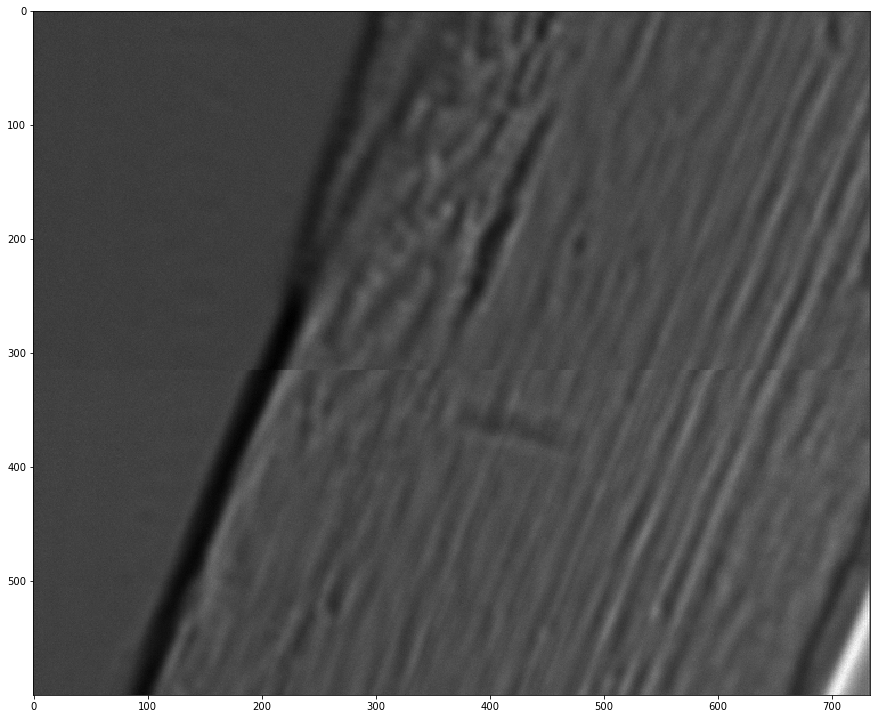

In [108]:
plt.figure(figsize = (15,15))
plt.imshow(test[1600:2200,1200:2500])

In [ ]:
# test stiching
test = np.concatenate([ff_corrected[5][:,:int(shifts[1])+127], ff_corrected[4]], axis = 1)


plt.figure(figsize = (15,15))
plt.imshow(test[1500:1750,1300:1700], cmap = 'gray', vmax = 2)

In [78]:
def Reverse(lst):
    return [ele for ele in reversed(lst)]


def stitchme_from_array_with_shift(data, shift = shift):
    
    # this part is questionable, shift should be calculated better 
    # now it's one shift for all files
    outs = []
    images = np.copy(data)
    
    for i in range(len(images)):
        images[i] = multiCTF.shift_image(images[i], np.asarray(shift))
    print('done with shifting')
    
    for ver in range(7):
        i=ver*17
        current_line = np.concatenate([k for k in reversed(images[i:i+17])], axis = 1)
        outs.append(current_line)
    
    # pack everything in one array and return one image
    outs = np.asarray(Reverse(outs))
    
    return (outs.reshape(outs.shape[0]*outs.shape[1], outs.shape[2]))

In [79]:
shift = [33.62, -14.43]

test = stitchme_from_array_with_shift(ff_corrected, shift = shift)

done with shifting


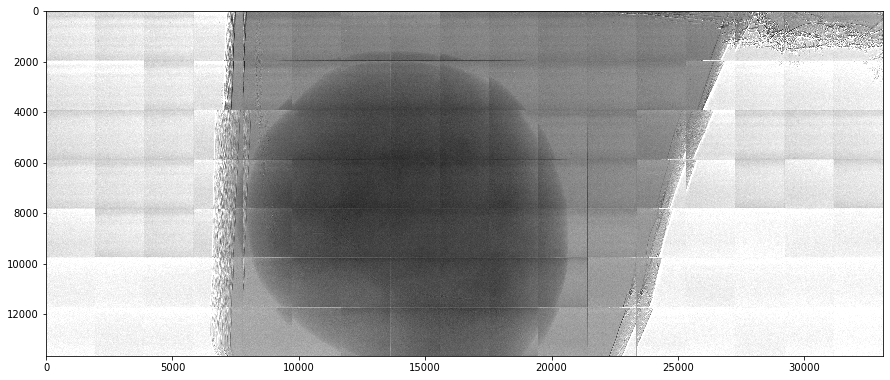

In [80]:
plt.figure(figsize = (15,15))
plt.imshow(test, cmap = 'gray', vmax = 1)

In [ ]:
print(1)

## Make Tomography

### Open and ff-correct one projection

In [452]:
motor_step_mm = 0.25*1e-3
pixel_size = 6.5/40 *1e-6
motor_step_pix = motor_step_mm/pixel_size 

image_size = 2048 - 100
crop_area = 2048 - int(motor_step_pix)

In [454]:
def open_one_ff_stitch(distance = '135mm',
                   image = '00001.tiff',
                   key = 'try0'):
    
    # open images
    print('### Started to open images for ', distance)
    data_test = find_paths_single_distance_all(imlist, key =key, distance = distance, image = image)
    data_test = sorted(data_test, key=lambda i: int(find_counter(i, start = distance + "_", end = "_"+image)))
    
    # open ff-s
    print('### Started to open flatfields for ', distance)
    ff_test = find_ffs_list(imlist, image_list = data_test)
    
    # ff-correct
    print('### Started ff-correction for ', distance)
    ff_corrected = []
    for counter,image in enumerate(data_test):
        ff_corrected.append(ff_correct_one(image, ff_test[0][0]))
    ff_corrected = np.asarray(ff_corrected)
    
    # stitch
    print('### Started stiching ', distance)
    result = stitchme_from_array(ff_corrected)
    
    # report on finishing and show results
    plt.imshow(result, cmap = 'gray', vmax = 1)
    print('Succesfully processed distance ', distance)
    
    return result

In [ ]:
whatever_list = 
path = 
filename = 'reconstruction_170122_test0'
shape = (N_proj, 3, ff[0].shape[1], ff[0].shape[2])



# create array to store the data
f = np.memmap(path+filename, dtype = 'float64', mode = 'w+', shape=shape) 
del f


for counter, value in enumerate(whatever_list):
    
    # process
    #process = open_one_ff_stitch(distance = '135mm', image = '00001.tiff')
    process = open_one_ff_stitch(distance = '135mm', image = value)
    
    # save 
    f = np.memmap(path+filename, dtype = 'float64', mode = 'r+', shape=shape) 
    f[counter, :] = reconstructme
    del f
    print('processed ', str(value))

### Started to open images for  135mm
### Started to open flatfields for  135mm
### Started ff-correction for  135mm
### Started stiching  135mm
Succesfully processed distance  135mm
### Started to open images for  152mm
### Started to open flatfields for  152mm
### Started ff-correction for  152mm
### Started stiching  152mm
Succesfully processed distance  152mm


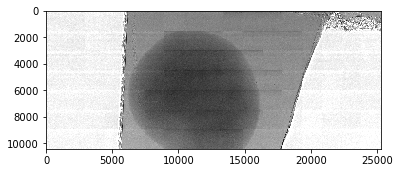

In [455]:
proj1_135 = open_one_ff_stitch(distance = '135mm', image = '00001.tiff')
proj1_152 = open_one_ff_stitch(distance = '152mm', image = '00001.tiff')

## phase retrieval

In [458]:
testme = [proj1_135, proj1_152]

In [459]:
# calculate shift of the image between the i-th and the 1-st distance
from maximus48 import multiCTF2 as multiCTF

shift = []

for i in np.arange(len(testme)):
    shift.append(multiCTF.shift_distance(testme[0], testme[i], 100))

print(shift)

[array([0., 0.]), array([ 31.05, -84.35])]


In [533]:
shift[0]

array([0., 0.])

In [462]:
result = testme

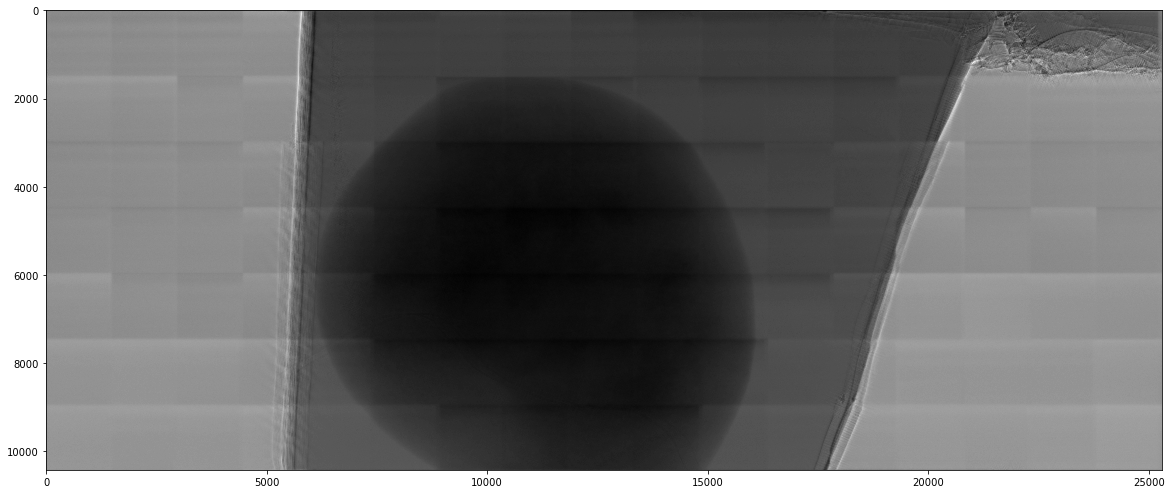

In [500]:
# Now, let's shift images 
out = multiCTF.shift_imageset(np.asarray(result), np.asarray(shift))
out = np.asarray(out)

# pixel size
pixel = 0.1625 * 1e-6                                                           

# distances 
distance = np.array((13.5,15.2), dtype = 'float32') * 1e-2                # distances of your measurements 
distance = np.array((20.3,22), dtype = 'float32') * 1e-2  

# photon energy
energy = 18   
wavelength = var.wavelen(energy)

# CTF parameters
beta_delta = 0.15
zero_compensation = 0.01


# Padding - in pixels for each side
#Npad = 200
#out = np.pad(out, ((0,0),(Npad, Npad),(Npad, Npad)), 'edge')  

# CTF-retrieval
fresnelN = pixel**2/(wavelength*distance)
final = multiCTF.multi_distance_CTF(out, beta_delta, fresnelN, zero_compensation)

# unpad images and show the result
#final = final[Npad:(final.shape[0]-Npad),Npad:(final.shape[1]-Npad)]                           
var.show(final)

# BITS AND PIECES

## find shift between two images

In [422]:
from maximus48.var import shift_distance

In [423]:
help (shift_distance)

Help on function shift_distance in module maximus48.var:

shift_distance(image1, image2, accuracy=100)
    Finds lateral shift between two images 
    
    Parameters
    __________
    image1 : 2D array
    
    image2 : 2D array
        y axis
    accuracy: int
        Upsampling factor. Images will be registered within 1 / upsample_factor of a pixel. For example upsample_factor == 20 means the images will be registered within 1/20th of a pixel.    
    
    Returns 
    __________
    
    shifts: ndarray
        Shift vector (in pixels) required to register target_image with src_image. 
        Axis ordering is consistent with numpy (e.g. Z, Y, X)



In [428]:
shifts = shift_distance(ff_corrected[5], ff_corrected[4])

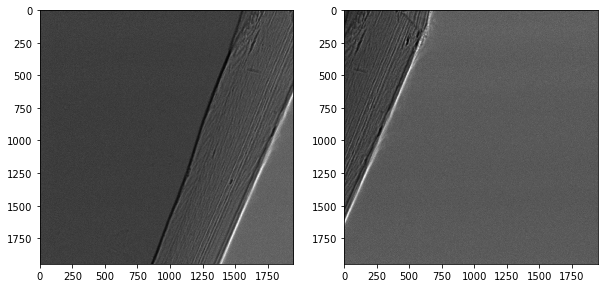

In [427]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
plt.gray()

ax[0].imshow(ff_corrected[5])
ax[1].imshow(ff_corrected[4])


In [431]:
int(shifts[1]

-559.11

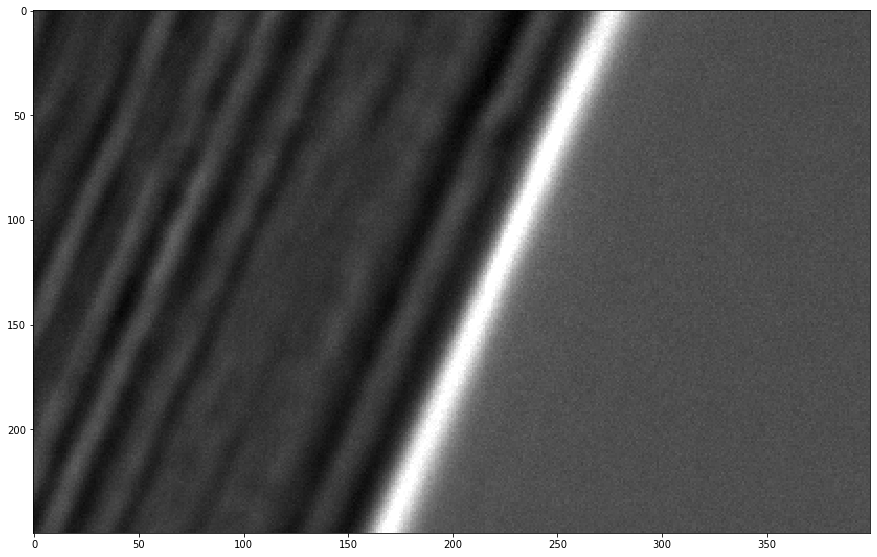

In [446]:
# test stiching
test = np.concatenate([ff_corrected[5][:,:int(shifts[1])+127], ff_corrected[4]], axis = 1)


plt.figure(figsize = (15,15))
plt.imshow(test[1500:1750,1300:1700], cmap = 'gray', vmax = 2)

didn't really work, need to try windowing, i.e. crop before and make images as similar as possible before calculating the shift

## ff-correction - beta version

**test data**

In [9]:
# select just one distance and one acquisition
def find_paths_single_distance(data_list, key):
    return [i for i in data_list if i.startswith(key)]
    #return [i for i in data_list if i.startswith('ff_try0_full_'+distance+'mm_'+section+'_')


In [94]:
# take some random set
data_test = find_paths_single_distance(imlist, 'try0_full_140mm_1')
ff_test = find_paths_single_distance(imlist, 'ff_try0_full_140mm_1')
data_test.sort(), ff_test.sort()


# note -> sort function could be improved 

(None, None)

In [95]:
#set the ROI of image first, the logic corresponds to FIJI (to be read (x,y,x1,y1 at the image - inverse to numpy!)
ROI = (100,100,2048,2048) 
folder = '/mnt/beegfs/P14/2020/p3l-gleb1/20201129/RAW_DATA/imaging/'
#folder = '/Users/au704469/Documents/Postdoc/Results/X-ray_tomography/Brain_organoid_P14_DESY_Nov2020/Data_test/'+distance+'mm/'


In [96]:
# test with just 3 images
image_data = data_test[:3]
ff_data = ff_test

In [97]:
images = np.asarray([tifffile.imread(folder+im) for im in image_data])
images = images[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

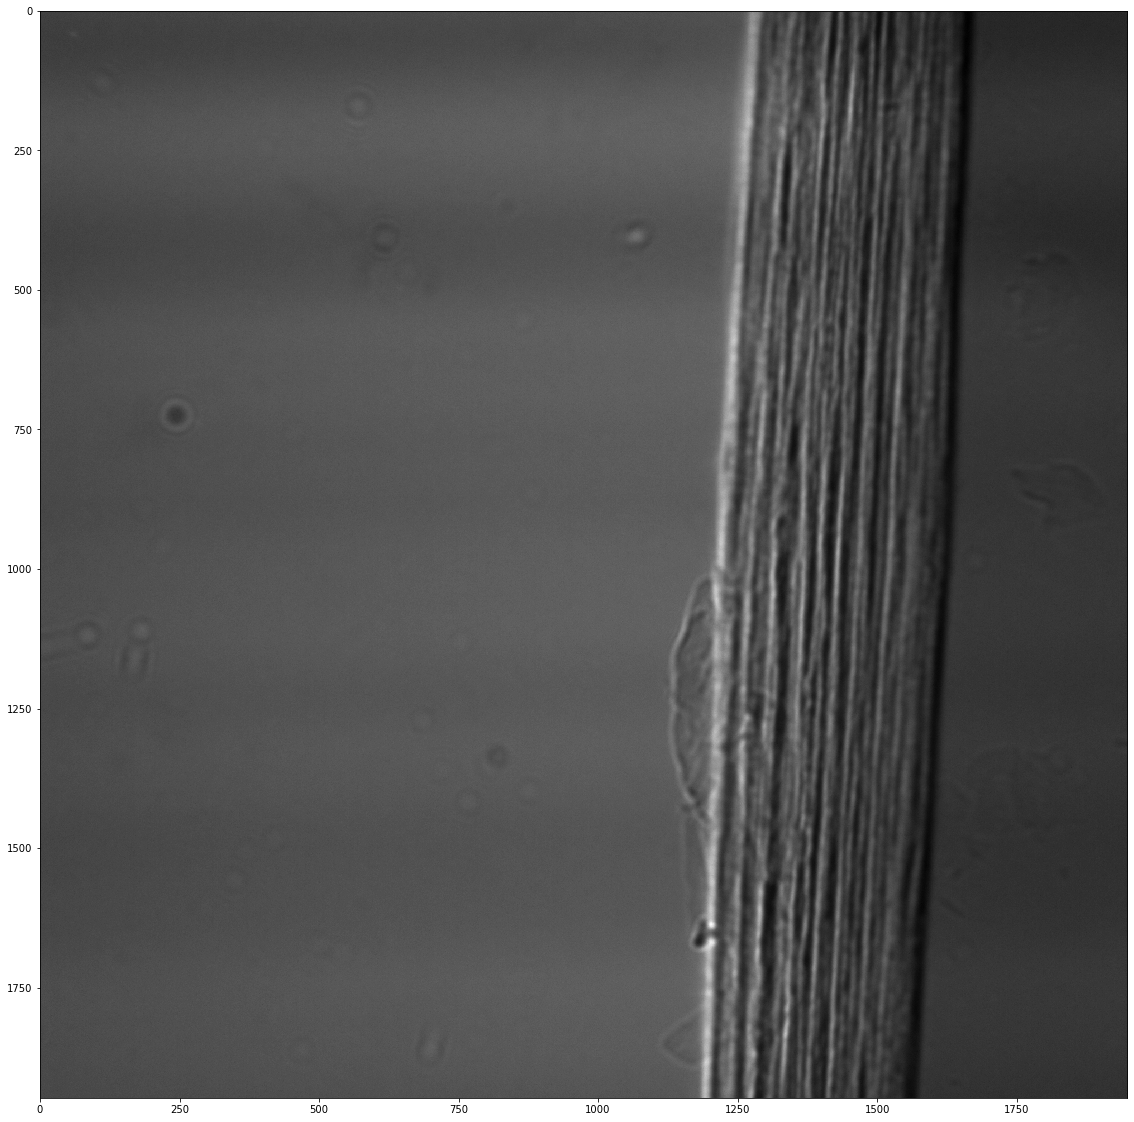

In [98]:
# not filtered image
var.show(images[2])

In [99]:
flatfield = np.asarray([tifffile.imread(folder+im) for im in ff_data])
flatfield = flatfield[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]
flatfield = np.transpose(flatfield, (1,2,0))

In [100]:
# images should be set as special classes:
ff_class = SSIM.SSIM_const(flatfield)

# a list to store results
result = []

for count,item in enumerate(images):
    image_class = SSIM.SSIM_const(item)
    index = SSIM.SSIM(image_class, ff_class).ssim()
    result.append(np.asarray(item/flatfield[:,:,np.argmax(index)]))
    print('processed image ', image_data[count])

processed image  try0_full_140mm_100_00001.tiff
processed image  try0_full_140mm_100_00002.tiff
processed image  try0_full_140mm_100_00003.tiff


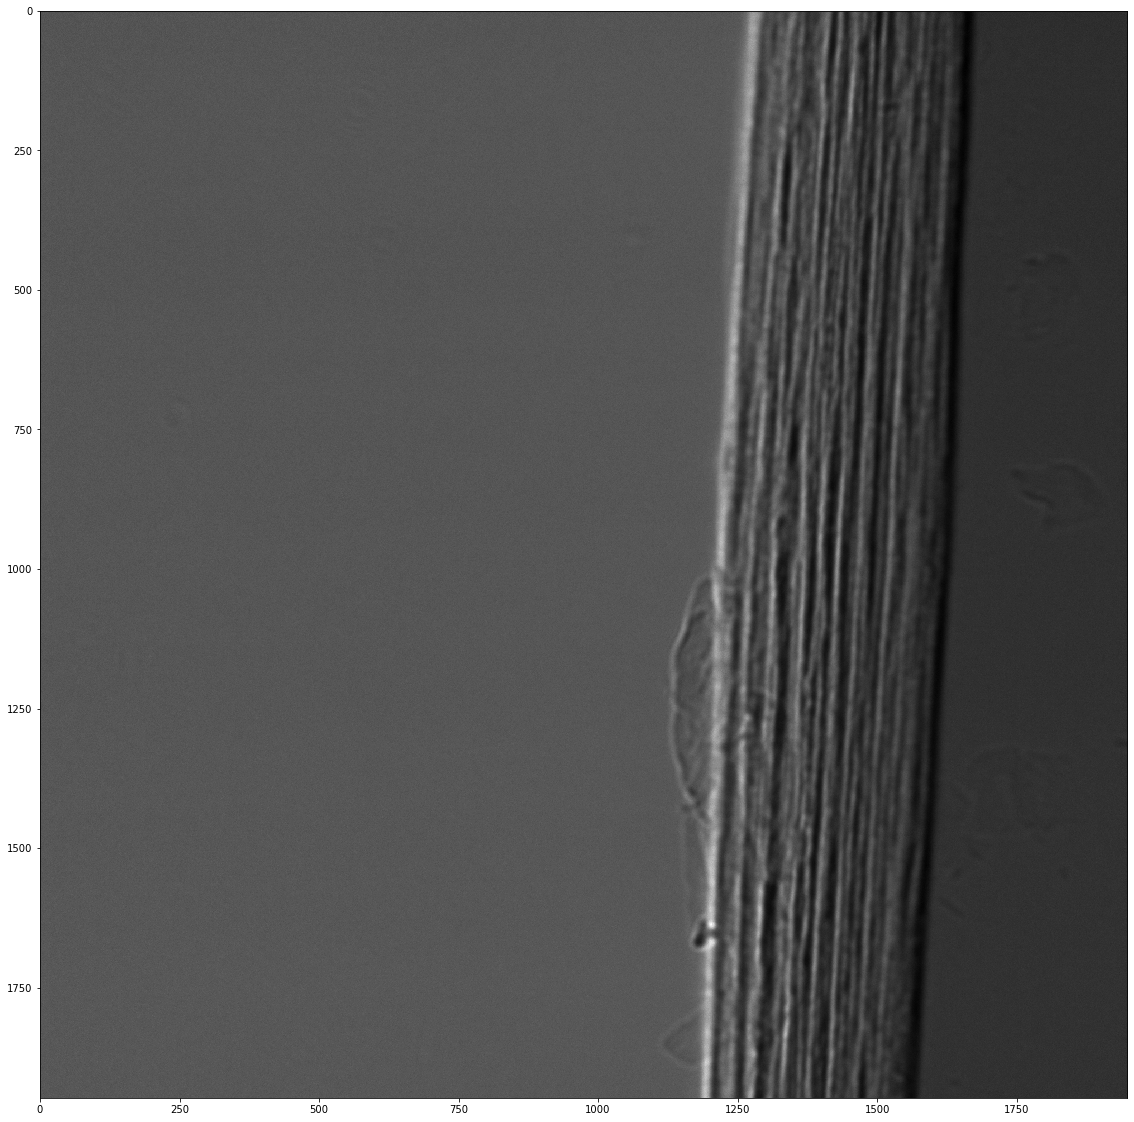

In [101]:
# filtered image
var.show(result[2])

**try a function for ff-correction**

In [105]:
def ff_correct_one(image_data, ff_data, ROI=(0,0,2048,2048)):    
    """
    This function takes 1 data image and ff corrects it
    
    image_data: str
        path to images
    ff_data: list
        paths to ff
        
    Returns
    out: 3D numpy array
    """
    

    # read images
    images = np.asarray([tifffile.imread(folder+im) for im in image_data])
    images = images[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    #read ff-files
    flatfield = np.asarray([tifffile.imread(folder+im) for im in ff_data])
    flatfield = flatfield[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    # please transpose the ff-array for the further ff-correction
    flatfield = np.transpose(flatfield, (1,2,0))
    
    # images should be set as special classes:
    image_class = SSIM.SSIM_const(images)
    ff_class = SSIM.SSIM_const(flatfield)

    # then, you can calculate SSIM metrics for each pair (data-image) - (ff-image)
    index = SSIM.SSIM(image_class, ff_class).ssim()

    # now, simply divide your image by flatfield-image with highest SSIM-index and get a corrected image:
    result = np.asarray(images[:]/flatfield[:,:,np.argmax(index)])
    return result






def ff_correct_list(image_data, ff_data, ROI=(0,0,2048,2048)):    
    """
    This function takes several data images and ff corrects it
    
    image_data: list
        paths to images
    ff_data: list
        paths to ff
        
    Returns
    out: 3D numpy array
    """
    

    # read images
    images = np.asarray([tifffile.imread(folder+im) for im in image_data])
    images = images[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    #read ff-files
    flatfield = np.asarray([tifffile.imread(folder+im) for im in ff_data])
    flatfield = flatfield[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    # please transpose the ff-array for the further ff-correction
    flatfield = np.transpose(flatfield, (1,2,0))
    
    # images should be set as special classes:
    ff_class = SSIM.SSIM_const(flatfield)

    # a list to store results
    result = []

    for count,item in enumerate(images):
        image_class = SSIM.SSIM_const(item)
        index = SSIM.SSIM(image_class, ff_class).ssim()
        result.append(np.asarray(item/flatfield[:,:,np.argmax(index)]))
        print('processed image ', image_data[count])
        
    return result


In [106]:
test = ff_correct_list(data_test[:3],ff_test, ROI=ROI)

processed image  try0_full_140mm_100_00001.tiff
processed image  try0_full_140mm_100_00002.tiff
processed image  try0_full_140mm_100_00003.tiff


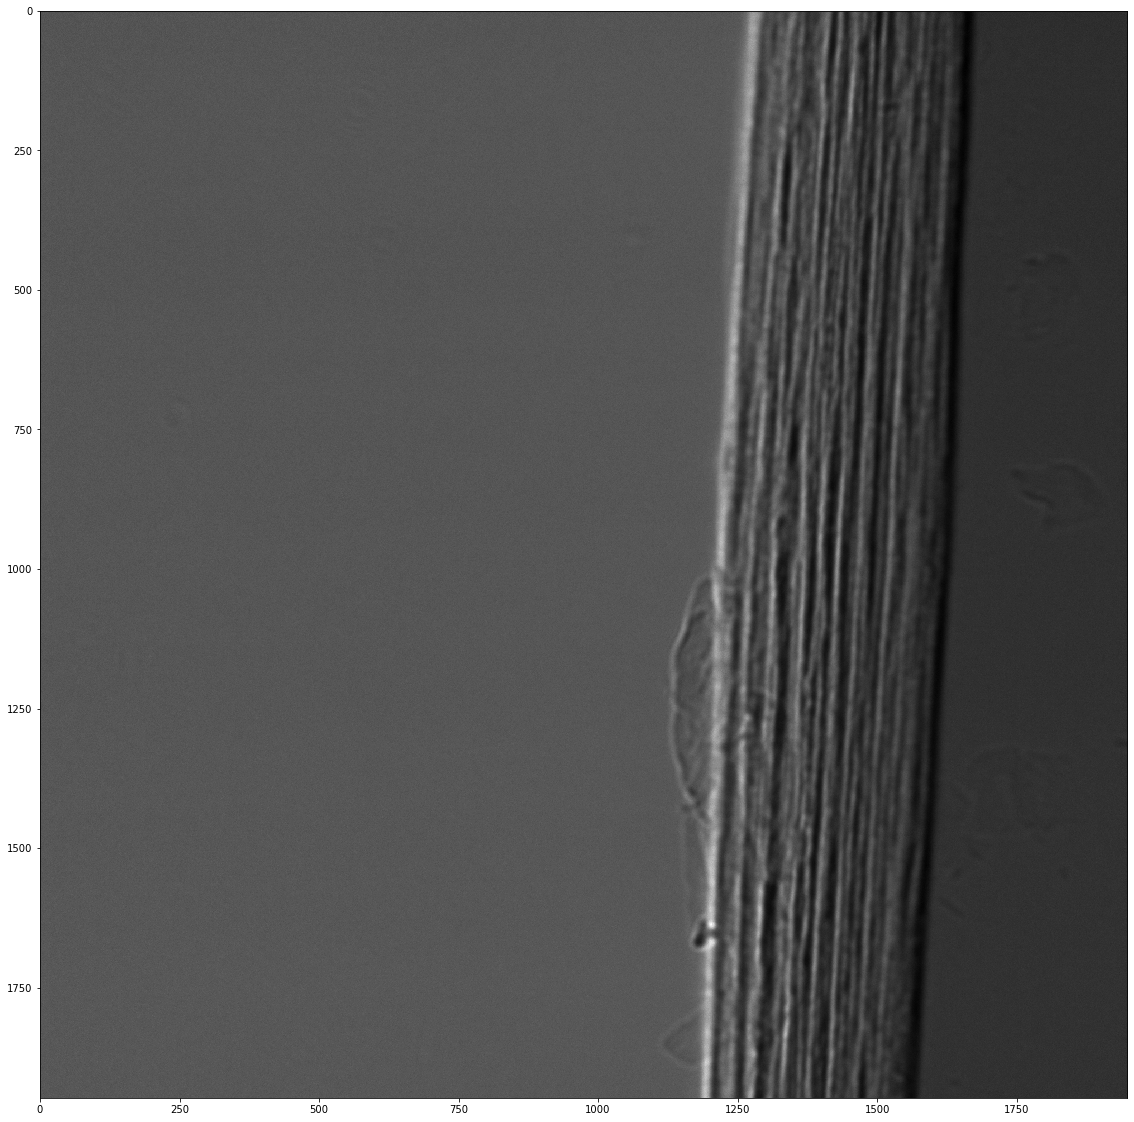

In [107]:
# filtered image
var.show(test[2])

## stitching - test approach

In [8]:
data_test = find_paths_single_distance_all(imlist, key ='try0', distance = '140mm', image = '0001.tiff')

# note - this sorting may not work for other examples (other than 140mm distance), needs to be tested
data_test = sorted(data_test, key=lambda i: int(find_counter(i)))

In [133]:
def Reverse(lst):
    return [ele for ele in reversed(lst)]

In [130]:
motor_step_mm = 0.25*1e-3
pixel_size = 6.25/40 *1e-6
motor_step_pix = motor_step_mm/pixel_size 

image_size = 2048
crop_area = 2048 - int(motor_step_pix)



list_of_images = data_test

full_paths = [folder + i for i in list_of_images]
images = tifffile.imread(full_paths)

# this part is questionable, the offset doesn't fit calculations (90 pix error)
images = images[:,:int(motor_step_pix)-90,:int(motor_step_pix)-90]

outs = []
for ver in range(7):
    i=ver*17
    current_line = np.concatenate([k for k in reversed(images[i:i+17])], axis = 1)
    outs.append(current_line)
    
outs = np.asarray(Reverse(outs))
newarr = outs.reshape(outs.shape[0]*outs.shape[1], outs.shape[2])

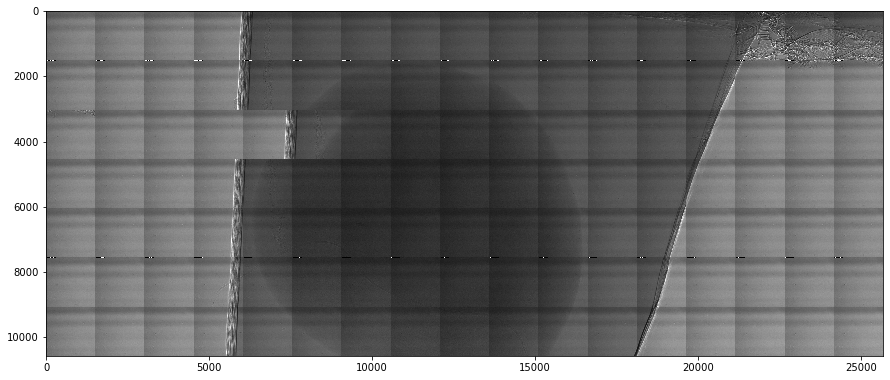

In [132]:
plt.figure(figsize = (15,15))
plt.imshow(newarr, cmap = 'gray', vmax = 20000)

**stichting - function**

In [140]:
def Reverse(lst):
    return [ele for ele in reversed(lst)]


def stitchme_from_list(list_of_images, folder = folder, crop = np.s_[:,:int(motor_step_pix)-90,:int(motor_step_pix)-90]):
    
    full_paths = [folder + i for i in list_of_images]
    images = tifffile.imread(full_paths)
    
    # this part is questionable, the offset should be calculated better above
    images = images[crop]
    
    outs = []
    for ver in range(7):
        i=ver*17
        current_line = np.concatenate([k for k in reversed(images[i:i+17])], axis = 1)
        outs.append(current_line)
    
    # pack everything in one array and return one image
    outs = np.asarray(Reverse(outs))
    
    return (outs.reshape(outs.shape[0]*outs.shape[1], outs.shape[2]))
  

In [141]:
motor_step_mm = 0.25*1e-3
pixel_size = 6.25/40 *1e-6
motor_step_pix = motor_step_mm/pixel_size 

image_size = 2048
crop_area = 2048 - int(motor_step_pix)


test = stitchme_from_list(data_test)

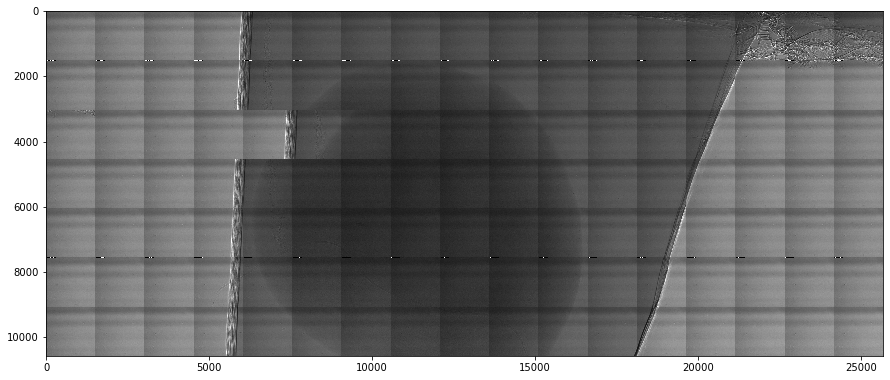

In [142]:
plt.figure(figsize = (15,15))
plt.imshow(test, cmap = 'gray', vmax = 20000)